# Identification of Potential Inhibitors for Tyrosine Kinase Enzyme Using Machine Learning Part 3 - Model Development & Analysis

---
**M. Alberto Moa**

The goal of this project is to identify potential drug targets by analyzing chemical and biological data using machine learning. Various models were tested, with AdaBoost Regressor achieving the best performance. This notebook walks through the data preparation, model building, and evaluation process.

## 1. Import Data and Required Package

Import Pandas, Numpy, Matplotlib, Seaborn, and SKLearn libraries.

In [2]:
# basic import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score

print('Imported Success')

Imported Success


Import the CSV data as DataFrame.

In [3]:
# Import feature and save it to X variable
X = pd.read_csv('feature.csv')

# Import target and save it to Y variable
y = pd.read_csv('target.csv')

In [4]:
# Display feature dataset
X.head()

,potential_duplicate,record_id,src_id,mw,logP,numHdonors,numHacceptors,activity_comment_inactive,activity_comment_uncertain,assay_type_B,bao_endpoint_BAO_0000190,bao_endpoint_BAO_0000192,bao_label_cell-based format,bao_label_single protein format,bao_label_subcellular format,relation_>,standard_relation_>
0,2.849394,-2.332247,-1.366821,-0.012081,1.104800,0.976969,-1.329198,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.350952,-2.228576,-1.366821,-1.591939,-1.260625,0.976969,-0.317105,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.350952,-2.228575,-1.366821,-0.258463,1.690420,-0.080034,-2.341291,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.350952,-2.218960,-1.366821,-1.007803,0.603921,-0.080034,-1.329198,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.350952,-2.170486,-1.366821,-0.920862,0.632986,2.033972,-1.835244,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [5]:
# Display target dataset
y.head()

,pIC50
0,14.636491
1,18.931506
2,15.919245
3,18.238359
4,14.731801


Preparation of feature and target done, next I will conduct model training.

## 2. Model Training

Preparing dataset into train and test set. Propotion of dataset is:

- 80% for train set
- 20% for test set

In [6]:
# splitting dataset to train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# show shape of splitting dataset
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((306, 17), (77, 17), (306, 1), (77, 1))

In [8]:
# Convert target to 1D array
y_train = y_train.values.ravel()

To identify the optimal model for predicting drug targets, I evaluated multiple algorithms on the training dataset: Linear Regression, Decision Tree Regressor, Random Forest Regressor, and AdaBoost Regressor. Each model was assessed using R² and RMSE metrics, which respectively measure the proportion of variance explained by the model and the average prediction error. 

Create an Evaluation Function to give all metrics after model training

In [9]:
# create a function of model evaluation
def evaluate_model(true, predicted):
    '''
    true = factual value of target
    predicted = predicted value of target
    '''
    
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2_square = r2_score(true, predicted)
    
    return rmse, r2_square

In [15]:
# define function to train dataset
def train(models, param_grids, X_train, y_train, cv=5):
    model_list = []
    r2_mean_list = []
    rmse_mean_list=[]
    best_params_list = []
    
    # Loop through each model in the dictionary
    for name, model in models.items():
        print(f"Tuning and Training: {name}")
        
        # If hyperparameters are provided for the model, run grid search
        if name in param_grids:
            grid = GridSearchCV(estimator=model, param_grid=param_grids[name], cv=3, scoring='r2', n_jobs=-1)
            grid.fit(X_train, y_train)
            best_model = grid.best_estimator_
            best_params = grid.best_params_
            print(f"Best parameters for {name}: {best_params}")
            best_params_list.append(best_params)
        else:
            best_model = model
            best_model.fit(X_train, y_train)
        
        # Perform k-fold cross-validation
        r2_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='r2')
        rmse_scores = np.sqrt(-cross_val_score(best_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error'))

        # Compute mean of scores
        r2_mean = np.mean(r2_scores)
        rmse_mean = np.mean(rmse_scores)

        # Append results to lists
        model_list.append(name)
        r2_mean_list.append(r2_mean)
        rmse_mean_list.append(rmse_mean)

        # Print cross-validation performance
        print(f'{name} Performance with {cv}-fold Cross-Validation:')
        print('- Mean R2 Score: {:.2f}'.format(r2_mean))
        print('- Mean RMSE: {:.2f}'.format(rmse_mean))
        print('='*30)
        print('\n')

    return model_list, r2_mean_list, rmse_mean_list, best_params_list

# Define models
models = {
    "Linear Regression" : LinearRegression(),
    "Decision Tree" : DecisionTreeRegressor(random_state=42),
    "Random Forest" : RandomForestRegressor(random_state=42),
    "AdaBoost Regressor": AdaBoostRegressor(random_state=42)
}

# Define hyperparameter grids for each model
param_grids = {
    "Decision Tree": {
        'max_depth': [3, 5, 10, 12],
        'min_samples_split': [2, 5, 10]
    },
    "Random Forest": {
        'n_estimators': [50, 100, 150],
        'max_depth': [3, 5, 10],
        'min_samples_split': [2, 5]
    },
    "AdaBoost Regressor": {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.05, 0.1, 1.0]
    }
}

# Call the function with models, hyperparameter grids, and data
model_list, r2_mean_list, rmse_mean_list, best_params_list = train(models, param_grids, X_train, y_train)

Tuning and Training: Linear Regression
Linear Regression Performance with 5-fold Cross-Validation:
- Mean R2 Score: 0.75
- Mean RMSE: 1.16


Tuning and Training: Decision Tree
Best parameters for Decision Tree: {'max_depth': 3, 'min_samples_split': 10}
Decision Tree Performance with 5-fold Cross-Validation:
- Mean R2 Score: 0.75
- Mean RMSE: 1.16


Tuning and Training: Random Forest
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
Random Forest Performance with 5-fold Cross-Validation:
- Mean R2 Score: 0.79
- Mean RMSE: 1.05


Tuning and Training: AdaBoost Regressor
Best parameters for AdaBoost Regressor: {'learning_rate': 0.1, 'n_estimators': 150}
AdaBoost Regressor Performance with 5-fold Cross-Validation:
- Mean R2 Score: 0.80
- Mean RMSE: 1.02




### Results

In [16]:
# Show RMSE and R2_score for training set
pd.DataFrame(list(zip(model_list, r2_mean_list, rmse_mean_list)), columns=['Model Name', 'R2_Score', 'RMSE_Score']).sort_values(by=['R2_Score'], ascending=False)

,Model Name,R2_Score,RMSE_Score
3,AdaBoost Regressor,0.804905,1.017456
2,Random Forest,0.785272,1.049643
0,Linear Regression,0.752138,1.163787
1,Decision Tree,0.750860,1.162380


**Model Performance Analysis**:
From metric score above, it shown:
- **AdaBoost Regressor**: Achieved the highest R² (0.8049) and lowest RMSE (1.0175), indicating strong predictive accuracy with minimal error. Its ability to handle complex relationships makes it the top-performing model.
- **Random Forest Regressor**: Closely followed AdaBoost with an R² of 0.7853 and RMSE of 1.0496, showing good accuracy but slightly higher error.
- **Linear Regression**: With an R² of 0.7521 and RMSE of 1.1638, this model captured only linear patterns, which limits its accuracy in this context.
- **Decision Tree Regressor**: Performed similarly to Linear Regression, with an R² of 0.7509 and RMSE of 1.1624, indicating that a single tree lacks the complexity needed for this task.

Based on training set performance, **AdaBoost Regressor** is selected as the best model for predicting drug targets, balancing high accuracy with low error. Next, we’ll evaluate AdaBoost’s performance on the test set and explore feature importance to understand which features most impact pIC50 values.

## 3. AdaBoost Resgressor Evaluation

Next, I will evaluate AdaBoost's performance on the test set.

In [18]:
# prediction for test set
model_ab = AdaBoostRegressor(learning_rate=0.1, n_estimators=150, random_state=42)
model_ab.fit(X_train, y_train)
y_test_pred = model_ab.predict(X_test)
mse= mean_squared_error(y_test, y_test_pred)
score = r2_score(y_test, y_test_pred)
rmse = np.sqrt(mse)

print('Accuracy of the model for test set is %.2f' %score)
print('RMSE of the model for test set is %.2f' %rmse)

Accuracy of the model for test set is 0.73
RMSE of the model for test set is 1.60


The AdaBoost Regressor performance shows:

- Accuracy: 0.73
- RMSE: 1.60

These results indicate that the AdaBoost Regressor maintains a reasonable level of accuracy on unseen data, with a manageable error. The performance on the test set confirms that this model is suitable for predicting drug targets.

### 3.1 Predicted vs Actual value Plot

Visually assess how well the model’s predictions align with the actual values.

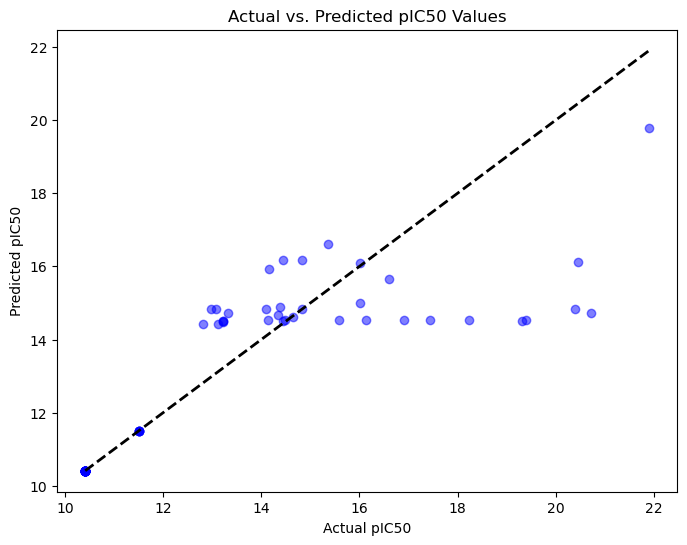

In [20]:
# Scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5, color='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual pIC50')
plt.ylabel('Predicted pIC50')
plt.title('Actual vs. Predicted pIC50 Values')
plt.show()


**Insights**:

- The model performs reasonably well for most data points but shows some inaccuracies with extreme values.
- There could be a need for additional feature engineering or data augmentation to improve predictions, especially for compounds with higher pIC50 values.

### 3.2 Feature Importance Analysis

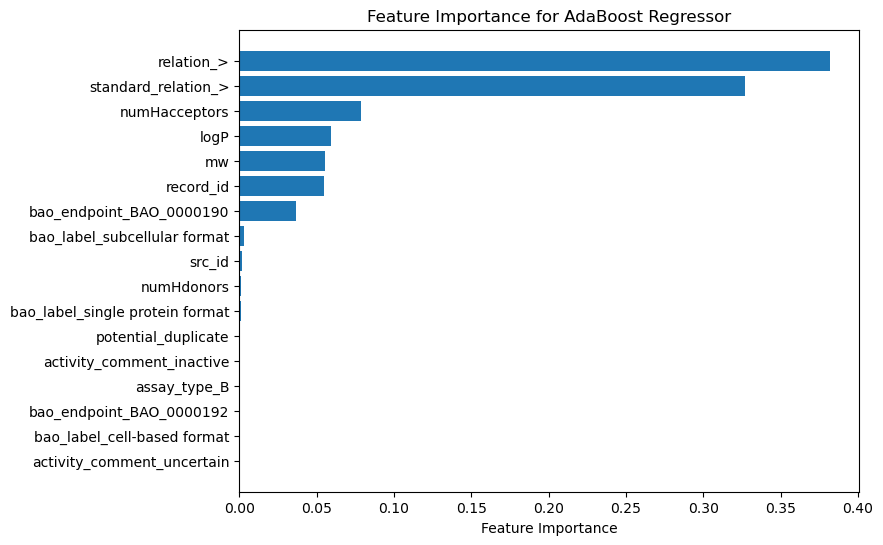

In [24]:
# Plotting feature importances
importances = model_ab.feature_importances_
feature_names = X.columns
sorted_indices = importances.argsort()

plt.figure(figsize=(8, 6))
plt.barh(range(len(importances)), importances[sorted_indices], align='center')
plt.yticks(range(len(importances)), [feature_names[i] for i in sorted_indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importance for AdaBoost Regressor')
plt.show()

**Insight**:
- The dominance of relation_> and standard_relation_> suggests that these categorical or binary indicators are critical in predicting pIC50 values. I will dive deeper into the relation_> and standard_relation_> features to understand their biological or chemical significance.
- Traditional chemical descriptors like numHAcceptors and logP also play a role, aligning with known SAR (structure-activity relationship) principles.
- The low importance of some features may indicate redundancy or irrelevance, suggesting that feature selection techniques (like removing low-importance features) could simplify the model without sacrificing performance.

### 3.3 Residual vs Predicted Values

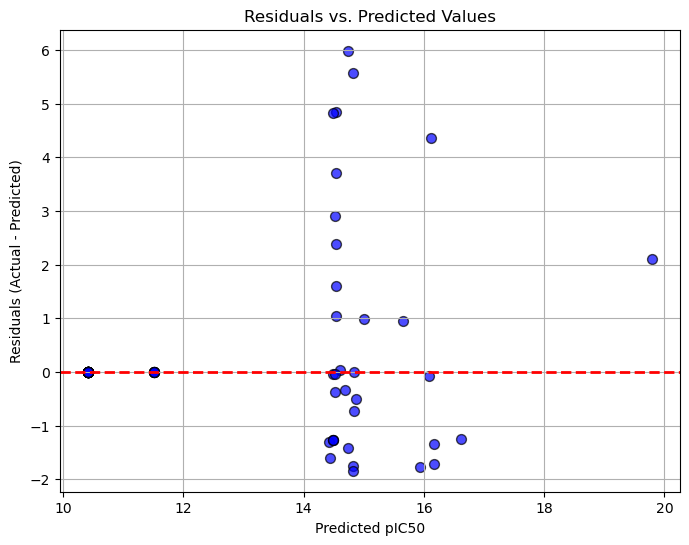

In [43]:
# Convert y_test dataframe to array 1D
y_test_ar = y_test.values.ravel()

# Calculate residuals
residuals = y_test_ar - y_test_pred

# Create the plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_pred, residuals, color='blue', alpha=0.7, edgecolors='k', s=50)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)  # Horizontal line at y = 0

# Add titles and labels
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted pIC50')
plt.ylabel('Residuals (Actual - Predicted)')

# Add grid for better readability
plt.grid(True)

# Show the plot
plt.show()


**Insight**:
- The residuals are mostly centered around zero, indicating no major bias in predictions.
- The model performs well for lower predicted pIC50 values (10-14), with minimal errors.
- Higher predicted pIC50 values (>16) show larger residuals, suggesting reduced model accuracy.

# General Conclusion

#### 1. Data Collection:
- The dataset was sourced and curated to study tyrosine kinase inhibitors, resulting in 383 entries, which represents a relatively small dataset for robust machine learning analysis.
- The features included molecular descriptors, bioactivity data (pIC50 values), and additional assay-related information, all crucial for predicting bioactivity.
- The small dataset size highlights the need for expanding data collection in future studies to improve model generalizability and performance.

#### 2. Exploratory Data Analysis (EDA):
EDA provided valuable insights into the data distribution and relationships between features:
- **pIC50 Distribution**: The distribution of pIC50 values highlighted a slight skew, with most values clustered in a specific range. This could indicate that the dataset predominantly focuses on compounds within a certain bioactivity threshold.
- **Feature Relationships**: Scatter plots revealed significant correlations between molecular descriptors like logP, numHacceptors, and pIC50 values, reinforcing their potential as key predictors.
- **Box Plots for Active vs. Inactive Compounds**: When splitting the data by activity thresholds, box plots showed distinguishable differences in key descriptors, indicating that these features could effectively separate active and inactive compounds.
- **Outliers**: A few extreme values in pIC50 and molecular descriptors were observed, suggesting the presence of unique or rare compounds. These might be valuable but could also introduce noise into the model.

#### 3. Data Preparation:
- Molecular descriptors were calculated and standardized to ensure all features were on the same scale.
- Features with high correlation or low relevance were removed to simplify the model and improve interpretability.

#### 4. Model Building and Evaluation:
- Four models were built and evaluated: Decision Tree, Random Forest, Linear Regression, and AdaBoost Regressor.
- The AdaBoost Regressor emerged as the best-performing model, with the following performance metrics: **Training Set**: R² = 0.8049, RMSE = 1.0175
**Test Set**: Accuracy = 0.73, RMSE = 1.60. The results indicate that the AdaBoost Regressor is capable of capturing the majority of the data's patterns but has some limitations in generalization due to the dataset size.

#### 5. Model Performance Analysis:
- The Predicted vs. Actual pIC50 plot showed the model’s ability to predict most values accurately, with higher residuals for extreme pIC50 values.
- The Residuals vs. Predicted Values plot revealed:
1. Residuals are centered around zero, suggesting no significant bias in the model.
2. Increased residual variance at higher pIC50 predictions and outliers, indicating potential areas for model improvement.
- Feature importance analysis highlighted key contributors to pIC50, such as relation_>, standard_relation_>, and molecular descriptors like logP and numHacceptors, providing insights into chemical properties influencing bioactivity.

#### 6. Key Insights and Takeaways:
- **Model Limitations:** While the AdaBoost Regressor performed well overall, the model struggles slightly with predictions at the higher pIC50 range, possibly due to the small dataset size and the presence of outliers.
- **Feature Impact:** The analysis of feature importance offers valuable insights into the chemical and biological factors driving bioactivity, which can guide future research in drug design.
- **Dataset Challenges:** The limited dataset size and variability underscore the need for further data collection, such as incorporating additional tyrosine kinase inhibitors or conducting more experimental assays to increase data diversity and reliability.

#### 7. Future Recommendations:
- Expand the dataset by sourcing more tyrosine kinase inhibitor data or conducting additional experiments to improve model robustness and generalizability.
- Address potential data imbalance and explore methods for handling outliers to improve model accuracy, particularly for extreme values.
- Experiment with more advanced machine learning models (e.g., Gradient Boosting, Neural Networks) or ensemble techniques to address the current model's limitations.
- Investigate the biological relevance of key features identified during feature importance analysis to validate their impact and inform experimental design.